In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import timeit
from timeit import default_timer as timer
import requests
from pathlib import Path 
import random
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
seed=torch.manual_seed(42)
BATCHSIZE=32
epochs=3
hidden_units=128

In [4]:
data_train=datasets.FashionMNIST(root="data",
                                train=True,
                                download=True,
                                transform=ToTensor(),
                                target_transform=None)

data_test =datasets.FashionMNIST(root="data",
                                train=False,
                                download=True,
                                transform=ToTensor(),
                                target_transform=None)

100%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [00:56<00:00, 465351.43it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 170569.93it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:05<00:00, 830714.98it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5197948.24it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [5]:
len(data_train.data), len(data_train.targets), len(data_test.data), len(data_test.targets)

(60000, 60000, 10000, 10000)

In [6]:
class_names = data_train.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, 'Ankle boot')

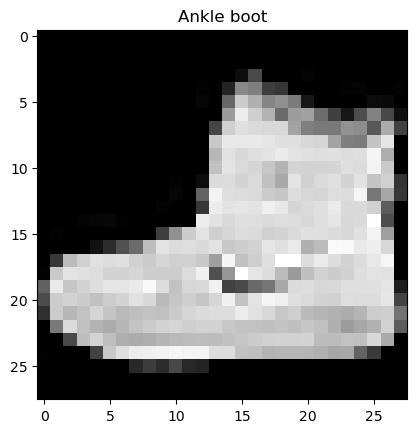

In [7]:
image,label=data_train[0]
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])

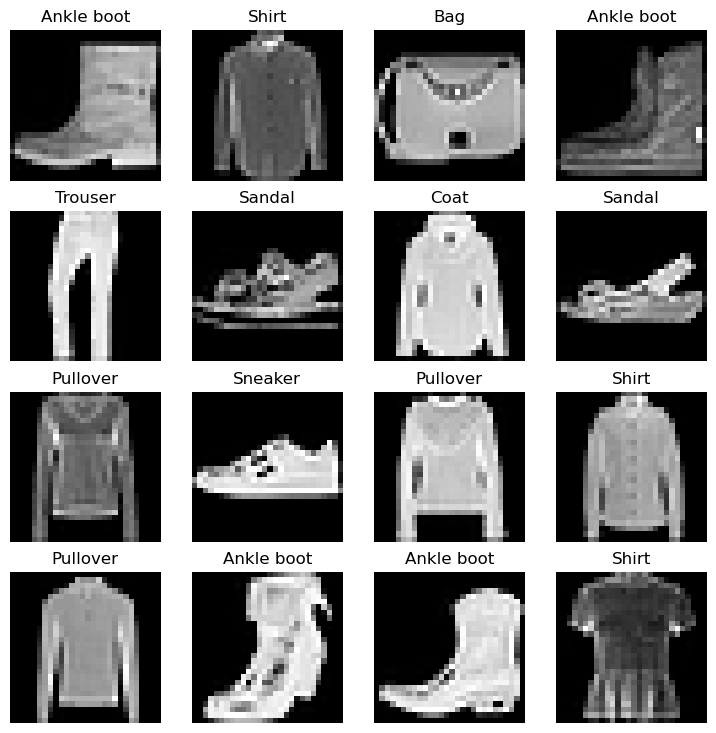

In [8]:
fig=plt.figure(figsize=(9,9))
row,column = 4,4
for i in range(1,row*column+1):
    random_idx = torch.randint(0, len(data_train), size=[1]).item()
    img, label = data_train[random_idx]
    fig.add_subplot(row, column, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [9]:
train_data=DataLoader(data_train,
                     batch_size=BATCHSIZE,
                     shuffle=True)
test_data=DataLoader(data_test,
                     batch_size=BATCHSIZE,
                     shuffle=False)

In [10]:
print(f"Dataloaders: {train_data, test_data}") 
print(f"Length of train dataloader: {len(train_data)} batches of {BATCHSIZE}")
print(f"Length of test dataloader: {len(test_data)} batches of {BATCHSIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002B236256510>, <torch.utils.data.dataloader.DataLoader object at 0x000002B22C8DDF50>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_data))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


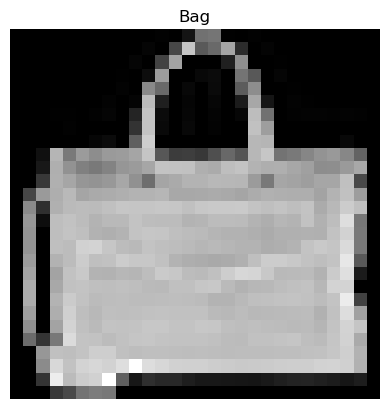

In [12]:
seed
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [13]:

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


helper_functions.py already exists, skipping download


In [14]:
class CNN(nn.Module):
    def __init__(self,input_shape:int ,hidden_layer_shape:int ,output_shape:int):
        super().__init__()
        self.con_layer_1= nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                                 out_channels=hidden_layer_shape,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=hidden_layer_shape,
                                                 out_channels=hidden_layer_shape,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2,)
                                       )    
        self.con_layer_2=nn.Sequential(nn.Conv2d(in_channels=hidden_layer_shape,
                                                 out_channels=hidden_layer_shape,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=hidden_layer_shape,
                                                 out_channels=hidden_layer_shape,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2,)
                                       )
        self.network_layer=nn.Sequential(nn.Flatten(),
                                 nn.Linear(in_features=hidden_layer_shape*7*7,
                                          out_features=output_shape))
    
    def forward(self,x:torch.Tensor):
        
        return self.network_layer(self.con_layer_2(self.con_layer_1(x)))

In [15]:
torch.manual_seed(42)
model= CNN(input_shape=1, 
    hidden_layer_shape=hidden_units, 
    output_shape=len(class_names)).to(device)
model

CNN(
  (con_layer_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con_layer_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (network_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [16]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),
                         lr=0.1)

In [17]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):


    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (x, y) in enumerate(data_loader):
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        loss=loss_fn(y_pred,y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}  | Train accuracy: {train_acc:.2f}%")


def test_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:
            x,y = x.to(device),y.to(device)
            test_pred = model(x)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [18]:
def duration(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [19]:
seed
train_start_time=timer()
for epoch in tqdm(range(epochs)):
    print(f"EPOCH : {epoch}\n--------------->")
    train_loop(data_loader=train_data, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device)
    test_loop(data_loader=test_data, 
        model=model, 
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device)
train_end_time = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 0
--------------->
Train loss: 0.49103  | Train accuracy: 82.76%
Test loss: 0.33443 | Test accuracy: 88.05%
EPOCH : 1
--------------->
Train loss: 0.28536  | Train accuracy: 89.77%
Test loss: 0.29366 | Test accuracy: 88.89%
EPOCH : 2
--------------->
Train loss: 0.24372  | Train accuracy: 91.23%
Test loss: 0.25844 | Test accuracy: 90.70%


In [20]:
total_train_time = duration(start=train_start_time,
                                    end=train_end_time,
                                    device=device)

Train time on cuda: 52.002 seconds


In [21]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
 
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y =X.to(device),y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [22]:
model_results = eval_model(
    model=model,
    data_loader=test_data,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'CNN',
 'model_loss': 0.2584403455257416,
 'model_acc': 90.70487220447285}

In [23]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
        return torch.stack(pred_probs)

In [24]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(data_test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 9 (Ankle boot)


In [25]:
pred_probs= make_predictions(model=model, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_probs[:2]

tensor([[2.8991e-07, 4.2827e-09, 2.0842e-07, 1.0373e-07, 1.2867e-07, 3.4644e-04,
         6.3122e-07, 5.9015e-04, 1.9572e-06, 9.9906e-01],
        [2.5433e-05, 9.0884e-07, 1.0071e-04, 1.6208e-04, 6.7813e-06, 1.5842e-04,
         1.0641e-05, 3.2494e-06, 9.9953e-01, 1.9288e-06]])

In [26]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([9, 8, 5, 4, 0, 3, 4, 9, 6], tensor([9, 8, 5, 4, 0, 3, 2, 9, 0]))

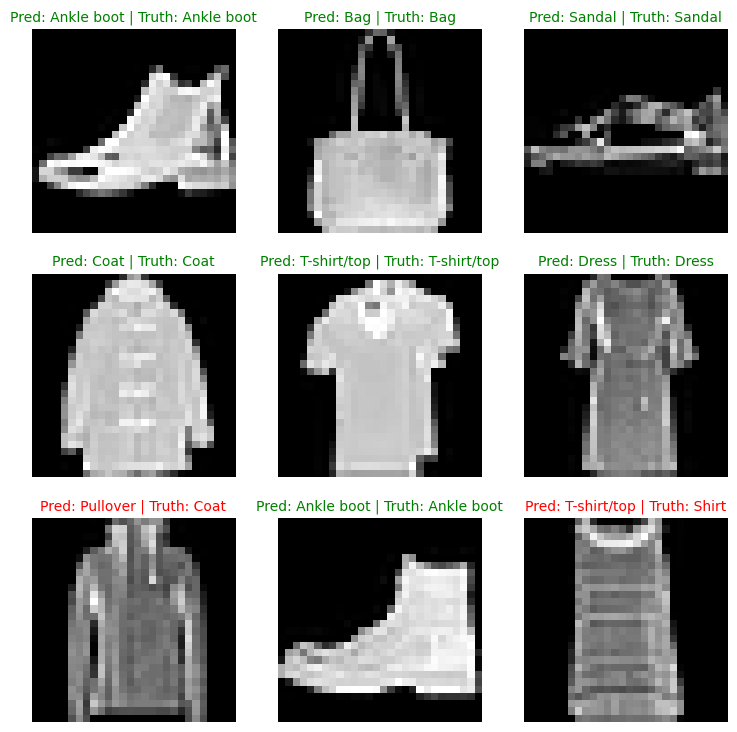

In [27]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") 
  else:
      plt.title(title_text, fontsize=10, c="r") 
  plt.axis(False);

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

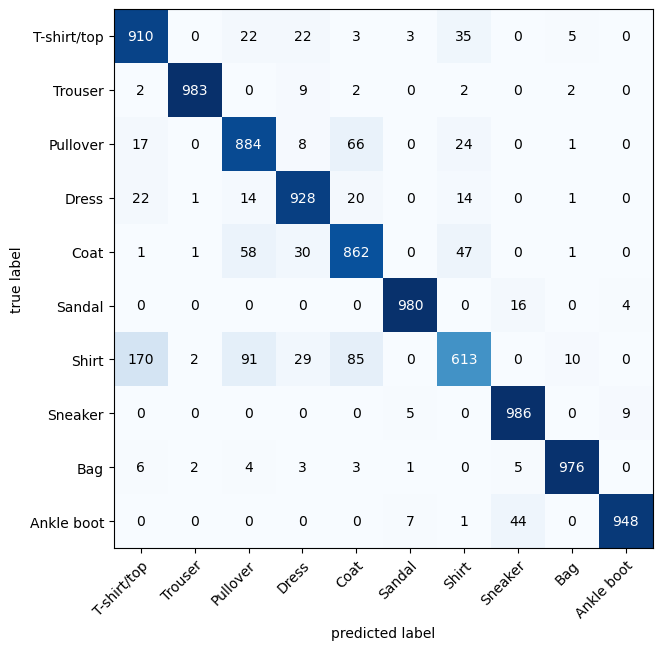

In [28]:

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_data, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=data_test.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [29]:

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, 
                 exist_ok=True 
)

MODEL_NAME = "pytorch_CNN_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_CNN_model.pth


In [30]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = CNN(input_shape=1, 
    hidden_layer_shape=hidden_units, 
    output_shape=len(class_names))

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [31]:
seed

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_data,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_results , model_results

({'model_name': 'CNN',
  'model_loss': 0.2584403455257416,
  'model_acc': 90.70487220447285},
 {'model_name': 'CNN',
  'model_loss': 0.2584403455257416,
  'model_acc': 90.70487220447285})

In [32]:
# Check to see if results are close to each other 
Is_same=torch.isclose(torch.tensor(model_results["model_loss"]), 
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance
if (Is_same==True):
    print("ORIGINAL MODEL AND LOADED MODEL ARE SAME")
else:
    print("ORIGINAL MODEL AND LOADED MODEL ARE DIFFERENT")

ORIGINAL MODEL AND LOADED MODEL ARE SAME
